# Preprocessing and Modeling

In [1]:
import pandas as pd
import numpy as np

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import KNNImputer
import category_encoders as ce

In [3]:
from joblib import load, dump

In [25]:
import plotly.express as px

In [4]:
black = 'graduation_rate_black_non-hispanic'
total = 'graduation_rate_total_cohort'

In [5]:
df = pd.read_csv("data/4_year/aggregate.csv", index_col=["UnitID", "institution_name"])
df.drop('Unnamed: 0', axis=1, inplace=True)

# Define X and Y

In [6]:
df['cohort'] = df['cohort'].astype(str)

In [7]:
categorical = df.select_dtypes('object').copy(deep=True)

In [8]:
numeric = df.select_dtypes(exclude='object').copy(deep=True)

In [9]:
grad_rates = numeric.filter(regex="graduation_rate").columns

In [10]:
grad_rates

Index(['graduation_rate_american_indian_or_alaska_native',
       'graduation_rate_asian',
       'graduation_rate_asian/native_hawaiian/other_pacific_islander',
       'graduation_rate_black_non-hispanic', 'graduation_rate_hispanic',
       'graduation_rate_men',
       'graduation_rate_native_hawaiian_or_other_pacific_islander',
       'graduation_rate_nonresident_alien',
       'graduation_rate_race/ethnicity_unknown',
       'graduation_rate_total_cohort', 'graduation_rate_two_or_more_races',
       'graduation_rate_white_non-hispanic', 'graduation_rate_women'],
      dtype='object')

In [11]:
y = numeric.loc[:,grad_rates]
numeric.drop(grad_rates, axis=1, inplace=True)

In [12]:
X = pd.concat([categorical, numeric], axis=1)

In [13]:
y

graduation_rate_american_indian_or_alaska_native  \
UnitID institution_name                                                                                       
100654 Alabama A & M University                                                                         NaN   
       Alabama A & M University                                                                       100.0   
100663 University of Alabama at Birmingham                                                              0.0   
       University of Alabama at Birmingham                                                             50.0   
100690 Amridge University                                                                               NaN   
...                                                                                                     ...   
492962 Indiana Institute of Technology-College of Prof...                                               NaN   
       Indiana Institute of Technology-College of Prof...                                              60.0   
494597 Faith Theological Seminary and Christian College                                                 NaN   
494603 Southwestern Baptist Theological Seminary                                                       50.0   
494685 Urshan College                                                                                   NaN   

                                                           graduation_rate_asian  \
UnitID institution_name                                                            
100654 Alabama A & M University                                              NaN   
       Alabama A & M University                                            100.0   
100663 University of Alabama at Birmingham                                  85.0   
       University of Alabama at Birmingham                                  79.0   
100690 Amridge University                                                    NaN   
...                                                                          ...   
492962 Indiana Institute of Technology-College of Prof...                  100.0   
       Indiana Institute of Technology-College of Prof...                   50.0   
494597 Faith Theological Seminary and Christian College                    100.0   
494603 Southwestern Baptist Theological Seminary                             0.0   
494685 Urshan College                                                        NaN   

                                                           graduation_rate_asian/native_hawaiian/other_pacific_islander  \
UnitID institution_name                                                                                                   
100654 Alabama A & M University                                                                          0.0              
       Alabama A & M University                                                                         67.0              
100663 University of Alabama at Birmingham                                                              85.0              
       University of Alabama at Birmingham                                                              79.0              
100690 Amridge University                                                                                NaN              
...                                                                                                      ...              
492962 Indiana Institute of Technology-College of Prof...                                               50.0              
       Indiana Institute of Technology-College of Prof...                                               25.0              
494597 Faith Theological Seminary and Christian College                                                100.0              
494603 Southwestern Baptist Theological Seminary                                                        50.0              
494685 Urshan College                         

# Train Test Split

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, y[total], test_size=0.25, random_state=42)

# Categorical Pipeline

In [76]:
categorical_preprocess = ColumnTransformer([
    ("Encode", ce.TargetEncoder(), make_column_selector(dtype_include="object")),
], remainder='drop')

# Float Pipeline

In [77]:
numeric_preprocess = Pipeline([
    ('Impute', ColumnTransformer([
        ("Impute", KNNImputer(), make_column_selector(dtype_include=float)),
        
    ], remainder='drop')),
    
    ('Scale', ColumnTransformer([
        ("Scaler", StandardScaler(), slice(200))
    ], remainder='passthrough'),)
])

# Int Pipeline

In [78]:
int_preprocess = ColumnTransformer([
        ("pass", "passthrough", make_column_selector(dtype_include=int)),
    ], remainder='drop')

In [79]:
int_preprocess.fit_transform(x_train).shape

(3450, 10)

In [80]:
len(x_train.select_dtypes(int).columns) + len(x_train.select_dtypes('float').columns) + len(x_train.select_dtypes("object").columns)

103

In [85]:
feature_union = FeatureUnion([
    ('categorical_preprocess', categorical_preprocess),
    ('numeric_preprocess', numeric_preprocess),
])

feature_union2 = FeatureUnion([
    ('int', int_preprocess),
    ('union1', feature_union),
    
])

In [82]:
transformed = feature_union2.fit_transform(x_train, y_train)

/Users/robertcampbell/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [83]:
preprocessed_df = pd.DataFrame(transformed)

## Preprocessing Results

In [84]:
preprocessed_df.head()

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.277010,-0.578930,1.010004,-0.035293,-0.407442,-0.399552,-0.349387,-0.393509,-0.407608,-0.413526
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.286519,-0.407135,-0.656620,0.558531,-0.407442,-0.399552,-0.349387,0.044918,-0.066987,-0.212337
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,-0.253941,-0.618356,0.285385,1.012631,-0.407442,-0.399552,-0.349387,-0.482180,-0.492764,-0.491406
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,-0.187629,-0.584581,0.937542,-0.314740,-0.407442,-0.399552,-0.349387,-0.309765,-0.362192,-0.420016
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,-0.030199,-0.616927,-0.149386,1.501662,-0.407442,-0.399552,-0.349387,-0.472328,-0.509795,-0.543326


## Pipeline

In [38]:
pipeline = Pipeline([
    ('preprocess', feature_union),
    ('regressor', xgb.XGBRegressor())
])

In [39]:
_ = pipeline.fit(x_train, y_train)

/Users/robertcampbell/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Pipeline(steps=[('preprocess',
                 FeatureUnion(transformer_list=[('categorical_preprocess',
                                                 ColumnTransformer(transformers=[('Encode',
                                                                                  TargetEncoder(),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f97d9e77850>)])),
                                                ('numeric_preprocess',
                                                 Pipeline(steps=[('Impute',
                                                                  ColumnTransformer(transformers=[('Impute',
                                                                                                   KNNImputer(),
                                                                                                   <sklearn.compose....
                              colsample_byt

In [40]:
y_hat = pipeline.predict(x_test)

In [41]:
mean_absolute_error(y_hat, y_test)

9.136489914977789

# Dump Objects

## Dump (x_train, x_test, y_train, y_test)

## Dump Model Log

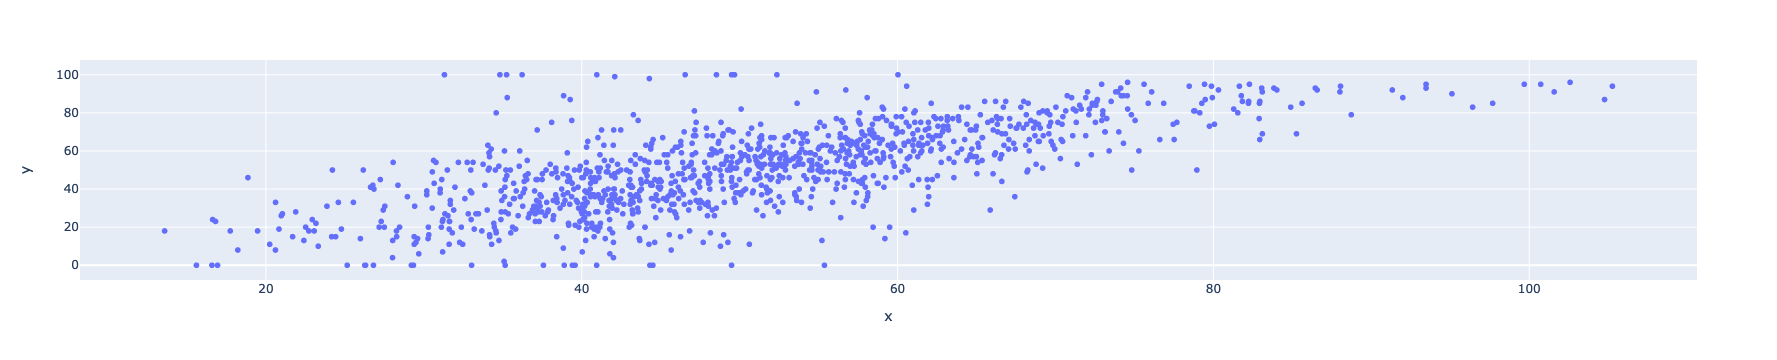

In [28]:
y_hat

array([70.15217448, 38.41147858, 73.52277606, ..., 48.43268282,
       65.34776975, 71.12874045])

In [29]:
y_test

UnitID  institution_name                                  
238333  Beloit College                                        75.0
475608  Criswell College                                      15.0
204501  Oberlin College                                       86.0
102669  Alaska Pacific University                             45.0
181446  Nebraska Wesleyan University                          63.0
                                                              ... 
184603  Fairleigh Dickinson University-Metropolitan Campus    49.0
160995  Beal University                                       32.0
142522  Brigham Young University-Idaho                        60.0
207582  Oral Roberts University                               55.0
192040  Jewish Theological Seminary of America                82.0
Name: graduation_rate_total_cohort, Length: 1151, dtype: float64